This project defines a model on movie genre prediction from plot analysis and other features and the dataset is taken from kaggle

Dataset link: 
- https://www.kaggle.com/datasets/guru001/movie-genre-prediction?select=test.csv

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import nltk
import string
import json
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [3]:
#Importing the files on which model is to be trained
train = pd.read_csv('train.csv')
train

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action
...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,Two loser pest control buddies find themselves...,scifi
53996,84712,The Great Swindle,A seductive woman gets involved in relationshi...,thriller
53997,69801,When Men Get Pregnant,"Duyen, a wedding dress staff, who decides to c...",romance
53998,7678,Suttu Pidikka Utharavu,The people of a crowded colony in Coimbatore c...,action


- # Data exploration

In [4]:
train.describe()

,id
count,54000.000000
mean,44994.882352
std,25980.135904
min,0.000000
25%,22569.750000
50%,45000.000000
75%,67466.250000
max,89999.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54000 non-null  int64 
 1   movie_name  54000 non-null  object
 2   synopsis    54000 non-null  object
 3   genre       54000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


In [6]:
#Checking for null values
train.isnull().sum()

id            0
movie_name    0
synopsis      0
genre         0
dtype: int64

In [7]:
#Importing test files
test = pd.read_csv('test.csv')
test

,id,movie_name,synopsis,genre
0,16863,A Death Sentence,"12 y.o. Ida's dad'll die without a DKK1,500,00...",action
1,48456,Intermedio,A group of four teenage friends become trapped...,action
2,41383,30 Chua Phai Tet,A guy left his home for 12 years till he came ...,action
3,84007,Paranoiac,A man long believed dead returns to the family...,action
4,40269,Ordinary Happiness,"After a deadly accident, Paolo comes back on E...",action
...,...,...,...,...
35995,73156,Mysterious Doctor Satan,A mad scientist plots the domination of Americ...,action
35996,21242,Blondes at Work,Steve promises his captain not to favor Torchy...,action
35997,70135,The Hurricane,A Polynesian sailor unjustly imprisoned after ...,action
35998,85987,Malayankunju,Anikkuttan is an ill-tempered electronics tech...,action


In [8]:
#Dropping the 'genre' column from test 
test.drop('genre',axis=1)

,id,movie_name,synopsis
0,16863,A Death Sentence,"12 y.o. Ida's dad'll die without a DKK1,500,00..."
1,48456,Intermedio,A group of four teenage friends become trapped...
2,41383,30 Chua Phai Tet,A guy left his home for 12 years till he came ...
3,84007,Paranoiac,A man long believed dead returns to the family...
4,40269,Ordinary Happiness,"After a deadly accident, Paolo comes back on E..."
...,...,...,...
35995,73156,Mysterious Doctor Satan,A mad scientist plots the domination of Americ...
35996,21242,Blondes at Work,Steve promises his captain not to favor Torchy...
35997,70135,The Hurricane,A Polynesian sailor unjustly imprisoned after ...
35998,85987,Malayankunju,Anikkuttan is an ill-tempered electronics tech...


In [9]:
train['genre'][0]

'fantasy'

In [10]:
train['genre'].value_counts()

genre
fantasy      5400
horror       5400
family       5400
scifi        5400
action       5400
crime        5400
adventure    5400
mystery      5400
romance      5400
thriller     5400
Name: count, dtype: int64

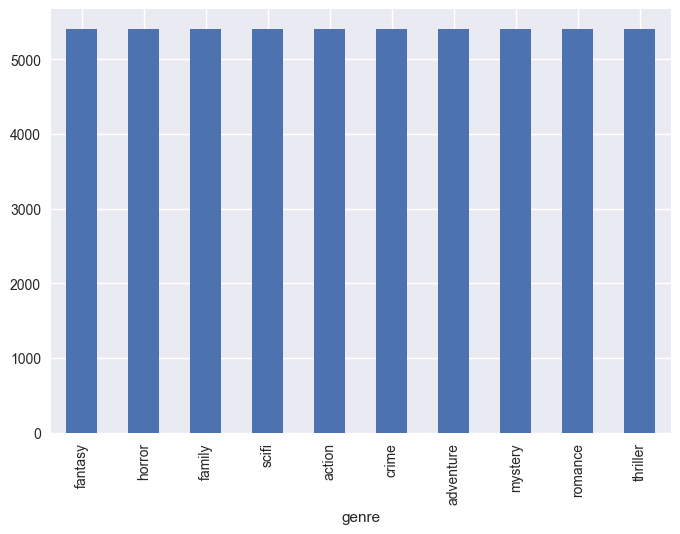

In [11]:
plt.style.use('seaborn')
train['genre'].value_counts().plot(kind = 'bar')
plt.show()

- # Preprocessing of data

In [12]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [14]:
#Cleaning train files
train['clean_plot'] = train['synopsis'].apply(lambda x: clean_text(x))

In [15]:
#Cleaning test files
test['clean_plot'] = test['synopsis'].apply(lambda x: clean_text(x))

In [16]:
test

,id,movie_name,synopsis,genre,clean_plot
0,16863,A Death Sentence,"12 y.o. Ida's dad'll die without a DKK1,500,00...",action,y o idas dadll die without a dkk operation ida...
1,48456,Intermedio,A group of four teenage friends become trapped...,action,a group of four teenage friends become trapped...
2,41383,30 Chua Phai Tet,A guy left his home for 12 years till he came ...,action,a guy left his home for years till he came bac...
3,84007,Paranoiac,A man long believed dead returns to the family...,action,a man long believed dead returns to the family...
4,40269,Ordinary Happiness,"After a deadly accident, Paolo comes back on E...",action,after a deadly accident paolo comes back on ea...
...,...,...,...,...,...
35995,73156,Mysterious Doctor Satan,A mad scientist plots the domination of Americ...,action,a mad scientist plots the domination of americ...
35996,21242,Blondes at Work,Steve promises his captain not to favor Torchy...,action,steve promises his captain not to favor torchy...
35997,70135,The Hurricane,A Polynesian sailor unjustly imprisoned after ...,action,a polynesian sailor unjustly imprisoned after ...
35998,85987,Malayankunju,Anikkuttan is an ill-tempered electronics tech...,action,anikkuttan is an ill tempered electronics tech...


In [17]:
train

,id,movie_name,synopsis,genre,clean_plot
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy,a young scriptwriter starts bringing valuable ...
1,50185,Entity Project,A director and her friends renting a haunted h...,horror,a director and her friends renting a haunted h...
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family,this is an educational video for families and ...
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi,scientists working in the austrian alps discov...
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action,buy day four men widely apart in life by night...
...,...,...,...,...,...
53995,80325,Untitled Monkeyshine/Ugly Brother Project,Two loser pest control buddies find themselves...,scifi,two loser pest control buddies find themselves...
53996,84712,The Great Swindle,A seductive woman gets involved in relationshi...,thriller,a seductive woman gets involved in relationshi...
53997,69801,When Men Get Pregnant,"Duyen, a wedding dress staff, who decides to c...",romance,duyen a wedding dress staff who decides to con...
53998,7678,Suttu Pidikka Utharavu,The people of a crowded colony in Coimbatore c...,action,the people of a crowded colony in coimbatore c...


- most frequent words in the clean_plot

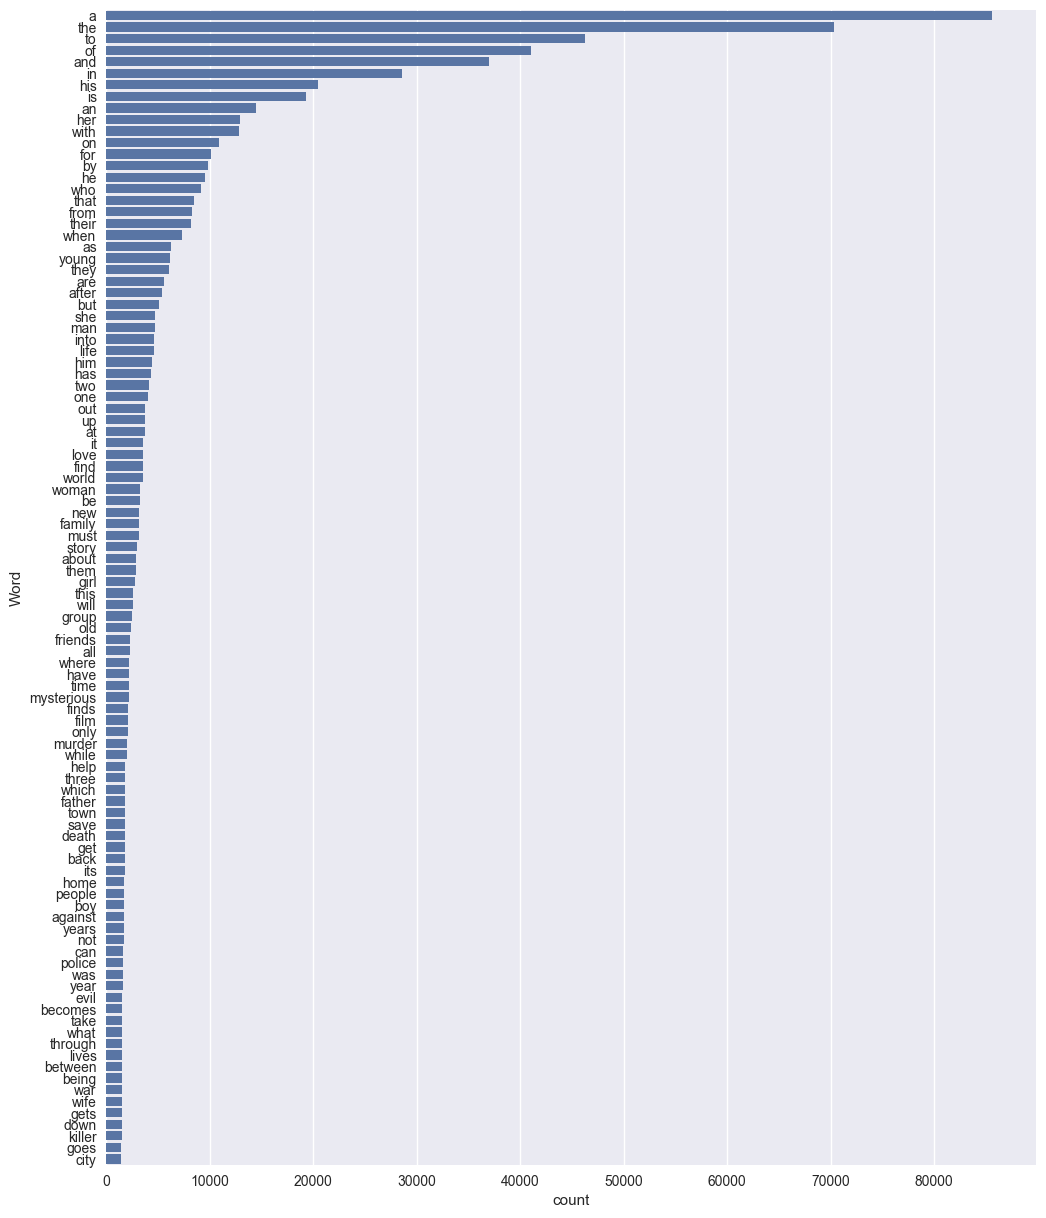

In [18]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})  
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show() 
freq_words(train['clean_plot'], 100)

- removing stopwords

In [19]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# removing stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

train['clean_plot'] = train['clean_plot'].apply(lambda x: remove_stopwords(x))

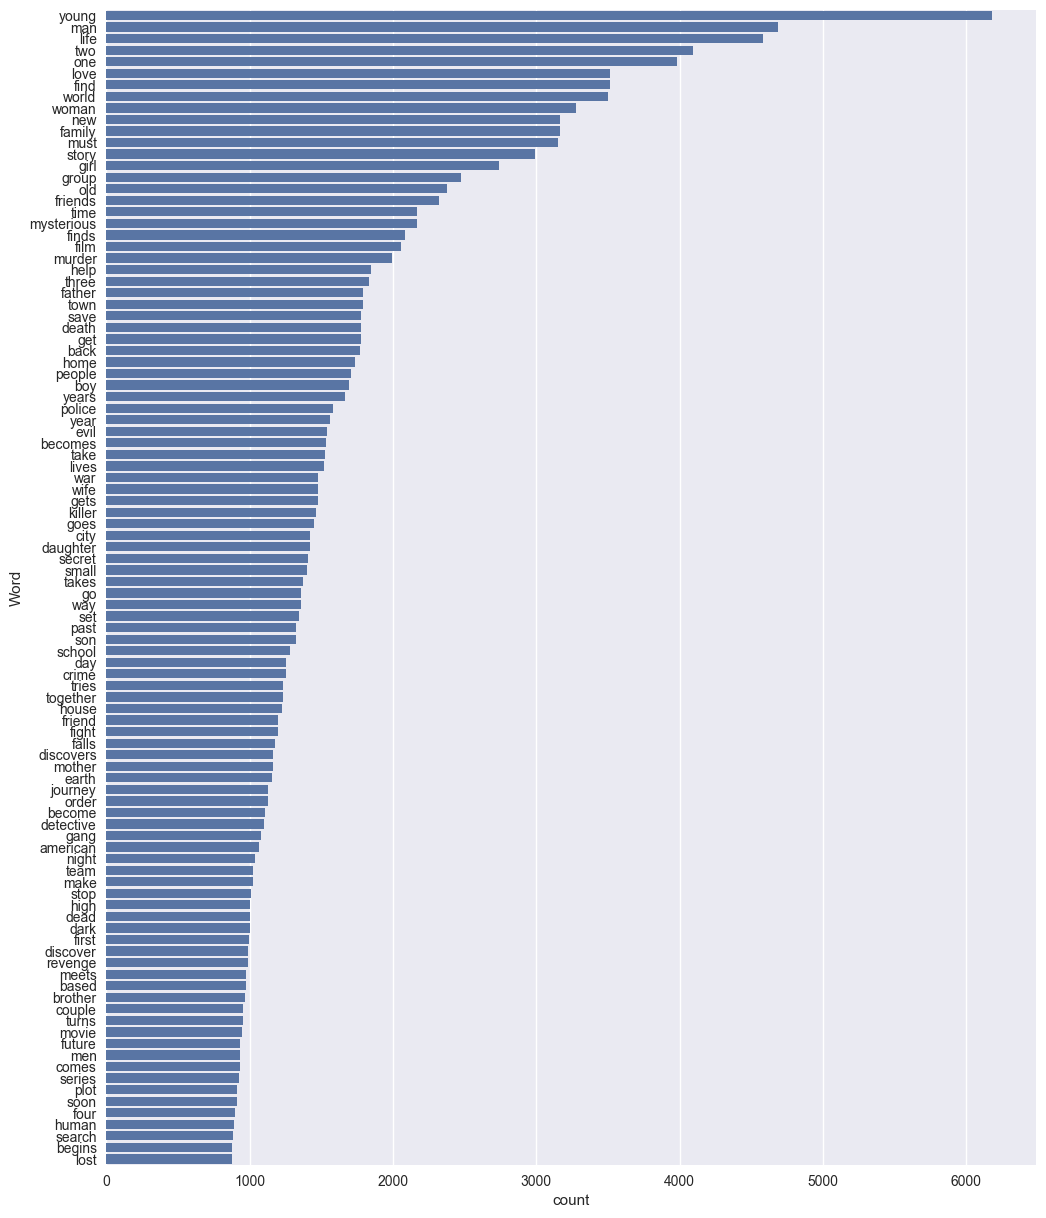

In [20]:
freq_words(train['clean_plot'], 100)

In [21]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train['clean_plot'])
X_test = tfidf_vectorizer.transform(test['clean_plot'])

In [22]:
# Split the data into training and testing sets
X = X_train
y = train['genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

- Using multinomial naive bayes model for classification

In [23]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.3510185185185185
              precision    recall  f1-score   support

      action       0.29      0.24      0.27      1094
   adventure       0.28      0.21      0.24      1067
       crime       0.36      0.40      0.38      1134
      family       0.40      0.43      0.41      1049
     fantasy       0.31      0.28      0.30      1057
      horror       0.39      0.46      0.42      1116
     mystery       0.28      0.29      0.28      1074
     romance       0.49      0.56      0.52      1075
       scifi       0.39      0.46      0.42      1077
    thriller       0.22      0.18      0.20      1057

    accuracy                           0.35     10800
   macro avg       0.34      0.35      0.34     10800
weighted avg       0.34      0.35      0.34     10800



- Creating an extra column as 'Predicted genre'

In [24]:
X_test_predictions = classifier.predict(X_test)
test['Predicted_Genre'] = X_test_predictions

In [25]:
# Save the data to the csv file
test.to_csv('predicted_genres.csv', index=False)

In [26]:
#Storing the predicted genres in a new csv file as 'predicted_genres.csv'
x = pd.read_csv('predicted_genres.csv')
x

,id,movie_name,synopsis,genre,clean_plot,Predicted_Genre
0,16863,A Death Sentence,"12 y.o. Ida's dad'll die without a DKK1,500,00...",action,y o idas dadll die without a dkk operation ida...,crime
1,48456,Intermedio,A group of four teenage friends become trapped...,action,a group of four teenage friends become trapped...,horror
2,41383,30 Chua Phai Tet,A guy left his home for 12 years till he came ...,action,a guy left his home for years till he came bac...,scifi
3,84007,Paranoiac,A man long believed dead returns to the family...,action,a man long believed dead returns to the family...,horror
4,40269,Ordinary Happiness,"After a deadly accident, Paolo comes back on E...",action,after a deadly accident paolo comes back on ea...,fantasy
...,...,...,...,...,...,...
35995,73156,Mysterious Doctor Satan,A mad scientist plots the domination of Americ...,action,a mad scientist plots the domination of americ...,scifi
35996,21242,Blondes at Work,Steve promises his captain not to favor Torchy...,action,steve promises his captain not to favor torchy...,mystery
35997,70135,The Hurricane,A Polynesian sailor unjustly imprisoned after ...,action,a polynesian sailor unjustly imprisoned after ...,adventure
35998,85987,Malayankunju,Anikkuttan is an ill-tempered electronics tech...,action,anikkuttan is an ill tempered electronics tech...,thriller
